In [1]:
import pickle
import warnings

import os, sys
WORKING_DIR = os.path.dirname(os.path.abspath(''))
sys.path.insert(1, os.path.join(WORKING_DIR,'LensQuEst'))
from tqdm import tqdm,trange

from universe import *
from halo_fit import *
from cmb import *
from flat_map import *
from weight import *
from pn_2d import *
import pickle
import seaborn as sns
from scipy.stats import spearmanr
import numpy as np
#######
IN_DATA_FNAMES = ['/oak/stanford/orgs/kipac/users/delon/LensQuEst/map_sims_%d.pkl'%(i) for i in range(1,51)]


pairs = [
#   [0,0], #N0
#   [0,1], #kappa
#   [1,0], #kappa
#   [0,2], #N1
#   [1,1], #N1
#   [2,0], #N1
#    [0,3], #should vanish
#    [1,2], #should vanish
#    [2,1], #should vanish
#    [3,0], #should vanish
#    [0,4], #N2 
#    [1,3], #N2
#    [2,2], #N2
#    [3,1], #N2
#    [4,0], #N2
   [-1, -1], #QE
   [-2, -2], #unlensed
]



warnings.filterwarnings("ignore")
#####

oup_fname = '../data/input/universe_Planck15/camb/CAMB_outputs.pkl'
print(oup_fname)
f = open(oup_fname, 'rb') 
powers,cl,c_lensed,c_lens_response = pickle.load(f)
f.close()

totCL=powers['total']
unlensedCL=powers['unlensed_scalar']

L = np.arange(unlensedCL.shape[0])

unlensedTT = unlensedCL[:,0]/(L*(L+1))*2*np.pi
F = unlensedTT
funlensedTT = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)

L = np.arange(cl.shape[0])
PP = cl[:,0]
rawPP = PP*2*np.pi/((L*(L+1))**2)
rawKK = L**4/4 * rawPP

fKK = interp1d(L, rawKK, kind='linear', bounds_error=False, fill_value=0.)

L = np.arange(totCL.shape[0])

lensedTT = totCL[:,0]/(L*(L+1))*2*np.pi
F = lensedTT
flensedTT = interp1d(L, F, kind='linear', bounds_error=False, fill_value=0.)


ftot = lambda l : flensedTT(l) + cmb.fForeground(l) + cmb.fdetectorNoise(l)


L = np.arange(c_lens_response.shape[0])

cTgradT = c_lens_response.T[0]/(L*(L+1))*2*np.pi

fTgradT = interp1d(L, cTgradT, kind='linear', bounds_error=False, fill_value=0.)

# In[3]:



# In[4]:




# In[5]:


print("Map properties")

# number of pixels for the flat map
nX = 1200
nY = 1200

# map dimensions in degrees
sizeX = 20.
sizeY = 20.

# basic map object
baseMap = FlatMap(nX=nX, nY=nY, sizeX=sizeX*np.pi/180., sizeY=sizeY*np.pi/180.)

# multipoles to include in the lensing reconstruction
lMin = 30.; lMax = 3.5e3

# ell bins for power spectra
nBins = 21  # number of bins
lRange = (1., 2.*lMax)  # range for power spectra


# In[6]:


print("CMB experiment properties")

# Adjust the lMin and lMax to the assumptions of the analysis
# CMB S3 specs
cmb = StageIVCMB(beam=1.4, noise=7., lMin=lMin, lMaxT=lMax, lMaxP=lMax, atm=False)

# # Total power spectrum, for the lens reconstruction
# # basiscally gets what we theoretically expect the
# # power spectrum will look like
# forCtotal = lambda l: ftot(l) 

# # reinterpolate: gain factor 10 in speed
# L = np.logspace(np.log10(lMin/2.), np.log10(2.*lMax), 1001, 10.)
# F = np.array(list(map(forCtotal, L)))
cmb.fCtotal = ftot

in_data = {}

for fname in tqdm(IN_DATA_FNAMES):
    f = open(fname, 'rb') 
    c_in_data = pickle.load(f) 
    f.close()
    for key in c_in_data:
        if(key not in in_data.keys()):
            in_data[key] = np.array(c_in_data[key])
        else:
            in_data[key] = np.vstack( (in_data[key],np.array(c_in_data[key])) )


for key in in_data:
    print(key, np.shape(in_data[key]))
    
    
pairs = [
    [0,0], #N0
    [0,1], #kappa
    [1,0], #kappa
    [1,1], #N1
    [0,2], #N1
    [2,0], #N1
    [-1, -1], #QE
    [-2, -2], #unlensed
]

data_names = {
    0: 'cmb0F_1',
    1: 'lCmbF_o1_1',
    2: 'lCmbF_o2_1',
    -1: 'lCmbF_1',
    -2: 'totalF_0',
}


ps_data = {}

../data/input/universe_Planck15/camb/CAMB_outputs.pkl
Map properties
CMB experiment properties


100%|██████████| 50/50 [08:58<00:00, 10.78s/it]


cmb0F_1 (500, 1200, 601)
kCmbF_1 (500, 1200, 601)
lCmbF_1 (500, 1200, 601)
fgF_1 (500, 1200, 601)
noiseF_1 (500, 1200, 601)
totalF_1 (500, 1200, 601)
totalF_0 (500, 1200, 601)
totalF_randomized_0 (500, 1200, 601)


In [2]:
in_data.keys()

dict_keys(['cmb0F_1', 'kCmbF_1', 'lCmbF_1', 'fgF_1', 'noiseF_1', 'totalF_1', 'totalF_0', 'totalF_randomized_0'])

In [3]:
in_data['cmb0F_1'].shape

(500, 1200, 601)

In [4]:
print("Gets a theoretical prediction for the noise")
fNqCmb_fft = baseMap.forecastN0Kappa(fTgradT, cmb.fCtotal, lMin=lMin, lMax=lMax, test=False)
Ntheory = lambda l: fNqCmb_fft(l) 

Gets a theoretical prediction for the noise
computing the reconstruction noise


In [5]:
import multiprocessing


TkTkps = []
TkpTks = []
TTps = []
TpTs = []


# Create a manager object
manager = multiprocessing.Manager()

# Create shared lists using the manager
TkTkps = manager.list()
TkpTks = manager.list()
TTps = manager.list()
TpTs = manager.list()

# Define a worker function for parallel processing
def process_data(s_idx):
    global TkTkps
    global TkpTks
    global TTps
    global TpTs

    #Qu+23 E10
    mapsF = [in_data['cmb0F_1'][s_idx], 
            in_data['cmb0F_1'][s_idx+100], 
            in_data['cmb0F_1'][s_idx+200],
            in_data['cmb0F_1'][s_idx+300]] 
    maps = list(map(baseMap.inverseFourier, mapsF))
    
    kappasF = [in_data['kCmbF_1'][s_idx+200], #commone lensinig potential
            in_data['kCmbF_1'][s_idx+200], #commone lensinig potential
            in_data['kCmbF_1'][s_idx],
            in_data['kCmbF_1'][s_idx+100]]
    
    #do lensing
    maps = [baseMap.doLensing(cmb0, kappaFourier=kappaF) 
            for cmb0, kappaF in zip(maps, kappasF)]
    mapsF = list(map(baseMap.fourier, maps))
    
    #apply foreground and noise
    fgsF  = [in_data['fgF_1'][s_idx], 
            in_data['fgF_1'][s_idx+100], 
            in_data['fgF_1'][s_idx+200],
            in_data['fgF_1'][s_idx+300]] 
    
    noisesF =  [in_data['noiseF_1'][s_idx], 
            in_data['noiseF_1'][s_idx+100], 
            in_data['noiseF_1'][s_idx+200],
            in_data['noiseF_1'][s_idx+300]] 
    
    
    mapsF = [mapF + fgF + noiseF for mapF, fgF, noiseF in zip(mapsF, fgsF, noisesF)]
    maps = list(map(baseMap.inverseFourier, mapsF))
    
    
    TkTkp = baseMap.computeQuadEstKappaNorm(fTgradT, cmb.fCtotal, 
                                         lMin=lMin, lMax=lMax, 
                                         dataFourier=mapsF[0],
                                         dataFourier2=mapsF[1])
    
    TkpTk = baseMap.computeQuadEstKappaNorm(fTgradT, cmb.fCtotal, 
                                         lMin=lMin, lMax=lMax, 
                                         dataFourier=mapsF[1],
                                         dataFourier2=mapsF[0])
    
    TTp   = baseMap.computeQuadEstKappaNorm(fTgradT, cmb.fCtotal, 
                                         lMin=lMin, lMax=lMax, 
                                         dataFourier=mapsF[2],
                                         dataFourier2=mapsF[3])
    
    TpT   = baseMap.computeQuadEstKappaNorm(fTgradT, cmb.fCtotal, 
                                         lMin=lMin, lMax=lMax, 
                                         dataFourier=mapsF[3],
                                         dataFourier2=mapsF[2])
    

    TkTkps.append(TkTkp)
    TkpTks.append(TkpTk)
    TTps.append(TTp)
    TpTs.append(TpT)
    
    
# Create a pool of worker processes
pool = multiprocessing.Pool()

# Map the worker function to the range of s_idx values
results = pool.map(process_data, range(100))
# Close the pool to indicate that no more tasks will be submitted
pool.close()

# Wait for all the worker processes to finish
pool.join()

In [6]:
np.array(TkTkps).shape

(100, 1200, 601)

In [7]:
def tmp_combine_Cl(Cls_tot):
    n_runs = np.shape(Cls_tot)[0]
    lCen = Cls_tot[0][0]
    Cls = np.sum(np.transpose(Cls_tot, axes=[1,2,0])[1], axis=1)
    sCls = np.sum(np.transpose(Cls_tot, axes=[1,2,0])[2], axis=1)
    return lCen, Cls, sCls

In [8]:
nBins = 51

In [9]:
c_data = None
ck = 'N1'
def compute_data(i, j):
    TTp = TTps[i]
    TpT = TpTs[i]
    TkTkp = TkTkps[j]
    TkpTk = TkpTks[j]
    curr_data = []

    for s, a, b in [[1, TkTkp, TkTkp], [1, TkTkp, TkpTk], [-1, TTp, TTp], [-1, TTp, TpT]]:
        t0, t1, t2 = baseMap.crossPowerSpectrum(dataFourier1=a, dataFourier2=b, nBins=nBins)
        curr_data.append([t0, s * t1, t2])

    c_ps_data = {}
    c_ps_data[ck] = [0, 0, 0]
    c_ps_data[ck][0], c_ps_data[ck][1], c_ps_data[ck][2] = tmp_combine_Cl(curr_data)
    
    return c_ps_data[ck]

pool = multiprocessing.Pool()

results = []
for i in trange(len(TTps)):
    for j in range(len(TkTkps)):
        results.append(pool.apply_async(compute_data, (i, j)))

pool.close()
pool.join()

for result in tqdm(results):
    if c_data is None:
        c_data = np.array([result.get()])
    else:
        c_data = np.vstack((c_data, np.array([result.get()])))

100%|██████████| 10000/10000 [00:04<00:00, 2399.60it/s]


In [10]:
print(c_data.shape)

(10000, 3, 50)


In [11]:
def combine_Cl(Cls_tot):
    n_runs = np.shape(Cls_tot)[0]
#     print(n_runs, np.shape(Cls_tot))
    lCen = Cls_tot[0][0]
    Cls = np.sum(np.transpose(Cls_tot, axes=[1,2,0])[1], axis=1)/n_runs
#     sCls = np.sqrt(np.sum(np.square(np.transpose(Cls_tot, axes=[1,2,0])[2]), axis=1))/n_runs
    sCls = np.std(np.transpose(Cls_tot, axes=[1,2,0])[1], axis=1)/np.sqrt(n_runs)
    return lCen, Cls, sCls

In [12]:
N1_mcmc = combine_Cl(c_data)

In [13]:
with open('/oak/stanford/orgs/kipac/users/delon/LensQuEst/N1-mcmc-nBins%d.pkl'%(nBins), "wb") as f:
    pickle.dump(N1_mcmc, f)

(1.1e-10, 0.0009)

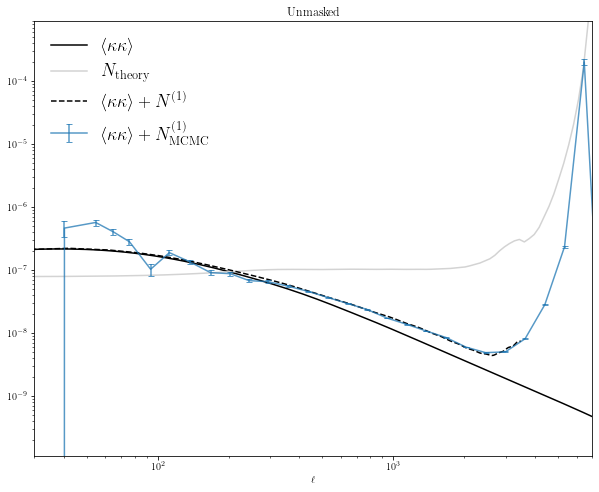

In [14]:
fig,ax = plt.subplots(nrows=1, figsize=(10,8))

ell = baseMap.l.flatten()
theory=[fKK, Ntheory]
theory_l=[r'$\big<\kappa\kappa\big>$', r'$N_{\rm theory}$']
theory_s=['black', 'lightgrey']
factor = lambda x : 1
for f,l,sty in zip(theory, theory_l, theory_s):
    L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
    ClExpected = np.array(list(map(f, L)))
    ax.plot(L, factor(L)*ClExpected, sty, label=l)
    
    
n1 = np.loadtxt('n1_data/N1_All_analytical.dat').T    
indices = ['TT', 'EE', 'EB', 'TE', 'TB', 'BB']
bins = n1[0]
n1_mat = np.reshape(n1[1:], (len(indices), len(indices), len(bins)))
for i in range(len(indices)):
    if(indices[i] != 'TT'):
        continue        
    n1_pp = (bins*(bins+1))**2/(2*np.pi)*(n1_mat[i][i][:])
    KK = fKK(bins)

    phiphi =  -2. * KK / bins**2
    phiphi *=  -2./ bins**2
    phiphi *= (bins*(bins+1))**2/(2*np.pi) #convention from CAMB 

    pp_n1 = phiphi+n1_pp

    KK_n1 = pp_n1 * 2*np.pi / (bins*(bins+1))**2 #back to our convention
    KK_n1 *= - bins**2 / 2
    KK_n1 *= - bins**2 / 2
    plt.plot(bins, KK_n1, 'k--', label=r'$\big<\kappa\kappa\big>+N^{(1)}$')

    
lCen, Cl, sCl = N1_mcmc
Ipos = np.where(Cl>0)

Ineg = np.where(Cl<0)



t0, t1 = baseMap.binTheoryPowerSpectrum(fKK, nBins=nBins)
t2 = np.zeros_like(t1)


ax.errorbar(lCen, (Cl+t1), yerr=sCl, alpha=.75, 
            fmt='-', capsize=3, capthick=1, label=r'$\left<\kappa\kappa\right>+N^{(1)}_{\rm MCMC}$')
# ax.errorbar(lCen[Ineg], (Cl[Ipos]+t1[Ineg]), yerr=sCl[Ineg], alpha=.75, 
#             fmt='--', capsize=3, capthick=1)#, label=r'$\left<\kappa\kappa\right>+N^{(1)}_{\rm MCMC}$')

ax.set_title('Unmasked')

ax.legend(frameon=False)
ax.set_xscale('log')
ax.set_xlabel(r'$\ell$')
ax.set_yscale('log')
ax.set_xlim(lMin,2*lMax)
ax.set_ylim(1.1e-10,.9e-3)


(1.1e-10, 0.0009)

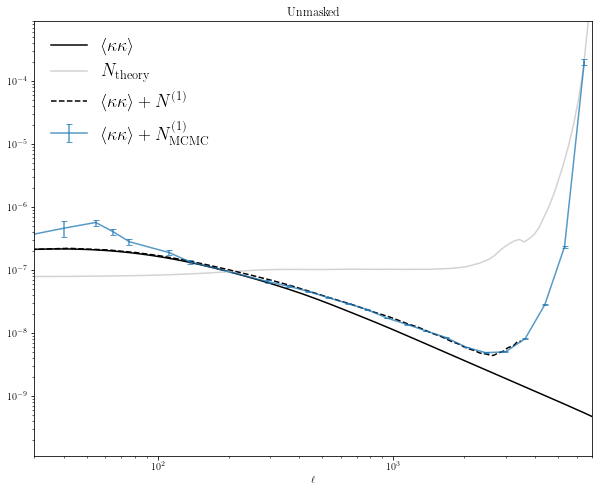

In [15]:
fig,ax = plt.subplots(nrows=1, figsize=(10,8))

ell = baseMap.l.flatten()
theory=[fKK, Ntheory]
theory_l=[r'$\big<\kappa\kappa\big>$', r'$N_{\rm theory}$']
theory_s=['black', 'lightgrey']
factor = lambda x : 1
for f,l,sty in zip(theory, theory_l, theory_s):
    L = np.logspace(np.log10(1.), np.log10(np.max(ell)), 201, 10.)
    ClExpected = np.array(list(map(f, L)))
    ax.plot(L, factor(L)*ClExpected, sty, label=l)
    
    
n1 = np.loadtxt('n1_data/N1_All_analytical.dat').T    
indices = ['TT', 'EE', 'EB', 'TE', 'TB', 'BB']
bins = n1[0]
n1_mat = np.reshape(n1[1:], (len(indices), len(indices), len(bins)))
for i in range(len(indices)):
    if(indices[i] != 'TT'):
        continue        
    n1_pp = (bins*(bins+1))**2/(2*np.pi)*(n1_mat[i][i][:])
    KK = fKK(bins)

    phiphi =  -2. * KK / bins**2
    phiphi *=  -2./ bins**2
    phiphi *= (bins*(bins+1))**2/(2*np.pi) #convention from CAMB 

    pp_n1 = phiphi+n1_pp

    KK_n1 = pp_n1 * 2*np.pi / (bins*(bins+1))**2 #back to our convention
    KK_n1 *= - bins**2 / 2
    KK_n1 *= - bins**2 / 2
    plt.plot(bins, KK_n1, 'k--', label=r'$\big<\kappa\kappa\big>+N^{(1)}$')

    
lCen, Cl, sCl = N1_mcmc
Ipos = np.where(Cl>0)

t0, t1 = baseMap.binTheoryPowerSpectrum(fKK, nBins=nBins)
t2 = np.zeros_like(t1)


ax.errorbar(lCen[Ipos], (Cl[Ipos]+t1[Ipos]), yerr=sCl[Ipos], alpha=.75, 
            fmt='-', capsize=3, capthick=1, label=r'$\left<\kappa\kappa\right>+N^{(1)}_{\rm MCMC}$')

ax.set_title('Unmasked')

ax.legend(frameon=False)
ax.set_xscale('log')
ax.set_xlabel(r'$\ell$')
ax.set_yscale('log')
ax.set_xlim(lMin,2*lMax)
ax.set_ylim(1.1e-10,.9e-3)